In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install numpy scipy pandas matplotlib numpy_ringbuffer sklearn

import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from strategy import Strategy
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

/usr/local/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


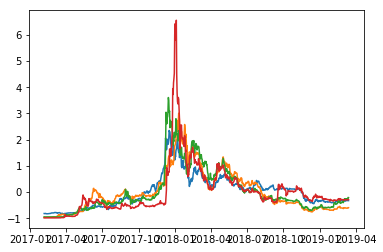

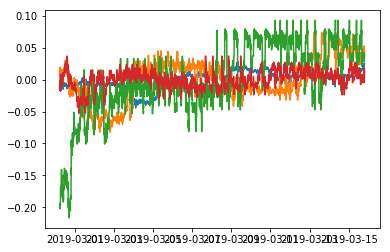

In [2]:
currencies = ['usd', 'btc', 'eth', 'ltc', 'xrp', 'eos']
pairs = [c + '_usd' for c in currencies if c != 'usd']
volume_keys = [c + '_tx_volume' for c in currencies if c != 'usd']

def prep_data(file):
    data = pickle.load(open(file, 'rb'))
    dates = [x['date'] for x in data]
    prices = [{k:v for k,v in x.items() if k in pairs} for x in data]
    volumes = [{(k.partition('_')[0] + '_usd'):v for k,v in x.items() if k in volume_keys} for x in data]
    return {
        'prices': pd.DataFrame(prices, index = dates),
        'volumes': pd.DataFrame(volumes, index = dates)
    }

def reduce_data(data, resampling):
    '''Averages prices, sums volumes'''
    prices = data['prices'].resample(resampling).first().fillna(method='ffill')
    volumes = data['volumes'].resample(resampling).sum().fillna(method='ffill')
    return { 'prices': prices, 'volumes': volumes }

def tail_data(data, n):
    '''get the last n points of the given data'''
    prices = data['prices'].tail(n)
    volumes = data['volumes'].tail(n)
    return { 'prices': prices, 'volumes': volumes }

def viz_data(data):
    '''Only plots prices for now'''
    plt.plot(data['prices'] / data['prices'].mean() - 1)
    plt.show()

def data_currencies(data):
    currencies = ['usd']
    for pair in data['prices'].columns:
        currencies.append(pair.partition('_')[0])
    return currencies

def find_gaps(data, freq):
    idx_ref = pd.date_range(start=data.index[0], end=data.index[-1],freq=freq)
    gaps = idx_ref[~idx_ref.isin(data.index)]
    return gaps

data = prep_data('data.p')
viz_data(data)
data_min = reduce_data(prep_data('data-minute.p'), '1Min')
data_5min = reduce_data(data_min, '5Min')
data_15min = reduce_data(data_min, '15Min')
viz_data(data_min)

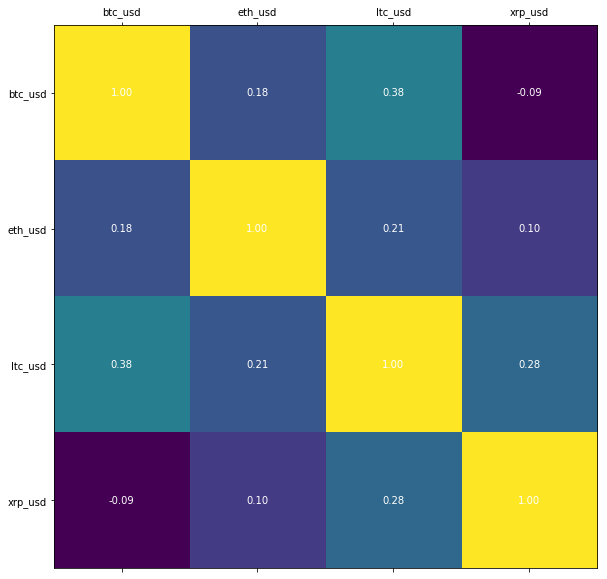

In [3]:
def plot_matrix(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(df)
    plt.xticks(range(len(df.columns)), df.columns);
    plt.yticks(range(len(df.index)), df.index);
    # Loop over data dimensions and create text annotations.
    for i in range(len(df.index)):
        for j in range(len(df.columns)):
            ax.text(j, i, '{:0.2f}'.format(df.iloc[i, j]), ha="center", va="center", color="w")

plot_matrix(data_15min['prices'].corr())

In [4]:
def cross_correlate_(x, y):
    return np.argmax(np.correlate(x, y, mode='full')) - len(x) + 1

def cross_correlate(df):
    '''Compute cross-correlation matrix for the given dataframe.'''
    ccs = pd.DataFrame(index=df.columns, columns=df.columns)
    for i in df.columns:
        for j in df.columns:
            if i == j:
                ccs.loc[i,j] = 0
                continue
            if np.isnan(ccs.loc[i,j]):
                ccs.loc[i,j] = cross_correlate_(df[i], df[j])
                ccs.loc[j,i] = -ccs.loc[i,j]
    return ccs

print(cross_correlate(pd.DataFrame([[1,2],[2,1],[1,2],[2,1],[1,2]])))
print(cross_correlate(pd.DataFrame([[1,1],[2,2],[3,3],[4,4],[5,5]])))
    
print(cross_correlate(data_min['prices']))

   0  1
0  0 -1
1  1  0
   0  1
0  0  0
1  0  0
         btc_usd  eth_usd  ltc_usd  xrp_usd
btc_usd        0        0        0        0
eth_usd        0        0        0        0
ltc_usd        0        0        0        0
xrp_usd        0        0        0        0


In [111]:
from strategy import Gaussian

######## Execution Environment ########
# 
# Note: Assumes all orders fill at last trade price. Attempting to simulate market-making would require
# combing through book and trade data, which is too much work for us to do at the moment.
    
# TODO: modularize execution models?
def get_orders(balances, prices, fairs, size, min_edge, max_edge, fees):
    '''Given current balances, prices, and fair estimates, determine which orders to place.
    Assumes all pairs are XXX_USD.
    `fairs` should be a Gaussian type. '''
    edges = (prices - fairs.mean) / fairs.stddev
    edges *= np.abs(fairs.mean / prices - 1) > fees # filter pct edges not better than fees
    balances = balances.drop(['usd']).rename(lambda c: c + '_usd')
    desired_balance_values = edges * -size
    orders = desired_balance_values / prices - balances
    return orders

def execute_orders(fees, prices, balances, orders):
    for (pair, size) in orders.items():
        currency = pair.partition("_")[0]
        value = size * prices[pair]
        balances['usd'] -= value
        balances['usd'] -= abs(value) * fees
        balances[currency] += size
        
def run(strategy, data, size = 1000, min_edge = 0, max_edge = 100, fees = 0):
    balances = pd.Series(dict.fromkeys(data_currencies(data), 0.))
    balances_ = []
    fairs_ = []
    index = data['prices'].index
    for (date, prices) in data['prices'].iterrows():
        volumes = data['volumes'].loc[date]
        
        fairs = strategy.step(prices, volumes)
        orders = get_orders(balances, prices, fairs, size, min_edge, max_edge, fees)
        execute_orders(fees, prices, balances, orders)
        
        fairs_.append(fairs)
        balances_.append(balances.copy())
    return {
        'data': data,
        'fair_means': pd.DataFrame([x.mean for x in fairs_], index=index),
        'fair_variances': pd.DataFrame([x.variance for x in fairs_], index=index),
        'balances': pd.DataFrame(balances_, index=index)
    }
        
######## Execution Analysis ########
        
# number of ticks to sum for price movements in risk calculation
risk_window = 10

def principal_market_movements(prices):
    '''Returns principal vectors for 1-stddev market movements, plus explained variance ratios'''
    # Fit PCA to scaled (mean 0, variance 1) matrix of single-tick price differences
    pca = PCA(n_components=0.97)
    scaler = StandardScaler()
    price_deltas = prices.diff().iloc[1:].rolling(risk_window).sum().iloc[risk_window:]
    price_deltas_scaled = scaler.fit_transform(price_deltas)
    pca.fit(price_deltas_scaled)
    pcs = pd.DataFrame(scaler.inverse_transform(pca.components_), columns = price_deltas.columns)
    return (pcs, pca.explained_variance_ratio_)

def max_abs_drawdown(pnls):
    '''Maximum peak-to-trough distance before a new peak is attained. The usual metric, expressed
    as a fraction of peak value, does not make sense in the infinite-leverage context.'''
    mdd = 0
    peak = -np.inf
    for pnl in pnls:
        if pnl > peak:
            peak = pnl
        if peak == 0:
            continue
        dd = peak - pnl
        if dd > mdd:
            mdd = dd
    return mdd

def analyze(results):
    '''Analyzes P/L and various risk metrics for the given run results.
    Plots balances (with P/L) and market risk over time.
    
    Note: RoRs are per-tick. They are NOT comparable across time scales.'''
    prices = results['data']['prices']
    # Balance values
    currency_prices = prices.rename(columns=lambda pair: pair.partition('_')[0])
    currency_prices['usd'] = 1
    balance_values = results['balances'] * currency_prices
    
    pnls = balance_values.sum(axis=1)
    
    # Market risk
    (pmms, pmm_weights) = principal_market_movements(prices)
    pair_balances = results['balances'].drop(columns=['usd']).rename(columns=lambda c: c +'_usd')
    component_risks = np.abs(pair_balances @ pmms.T)
    risks = component_risks @ pmm_weights
    
    total_positions = np.abs(balance_values.drop(columns=['usd']).values).sum()
    
    edges = (prices - results['fair_means']) / prices
    
    fig, axs = plt.subplots(1,2, figsize=(16, 4))
    balance_values.plot(ax=axs[0])
    pd.DataFrame(pnls, columns=["P/L"]).plot(ax=axs[0])
    edges.plot(ax=axs[1])
    axs[1].axhline(0, color='grey')
    plt.show()
    pnl = pnls.iloc[-1]
    print('Return on maximum market risk: {0}'.format(pnl / (risks.values.max() + 1e-10)))
    print('Return on total market risk:   {0}'.format(pnl / (risks.values.sum() + 1e-10)))
    print('Return on total positions:     {0}'.format(pnl / (total_positions + 1e-10)))
    print('Sharpe ratio:                  {0}'.format(pnl / (pnls.std() + 1e-10)))
    print('Final P/L:                     {0}'.format(pnl))
    print('Maximum absolute drawdown:     {0}'.format(max_abs_drawdown(pnls)))
    print('Maximum market risk:           {0}'.format(risks.values.max()))
    print('Final balances:')
    print(results['balances'].iloc[-1])

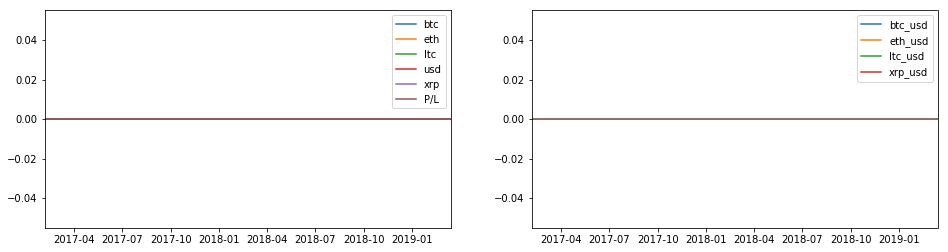

Return on maximum market risk: 0.0
Return on total market risk:   0.0
Return on total positions:     0.0
Sharpe ratio:                  0.0
Final P/L:                     0.0
Maximum absolute drawdown:     0
Maximum market risk:           0.0
Final balances:
usd    0.0
btc    0.0
eth    0.0
ltc    0.0
xrp    0.0
Name: 2019-03-14, dtype: float64


In [112]:
from strategy import HoldStrategy

analyze(run(HoldStrategy(), data))

In [ ]:
from strategy import MovingAverage, Gaussian
from numpy_ringbuffer import RingBuffer
from math import log1p, sqrt

class KalmanFilter(Strategy):
    '''Predicts fairs based on correlated movements between pairs. All inputs should be cointegrated.
    '''
    def __init__(self, correlation_window_size, movement_half_life):
        self.moving_prices_history = None
        self.correlation_window_size = correlation_window_size
        self.moving_prices = MovingAverage(movement_half_life)
        self.moving_volumes = MovingAverage(movement_half_life)
        self.prev_prediction = None
        
    def step(self, prices, volumes):
        if self.moving_prices_history is None:
            self.moving_prices_history = RingBuffer(self.correlation_window_size, dtype=(np.float, len(prices.index)))
        
        if self.prev_prediction is None:
            self.prev_prediction = self.null_estimate(prices)
        
        self.moving_prices.step(prices)
        self.moving_volumes.step(volumes)

        if not self.moving_prices.ready:
            return self.null_estimate(prices)
        
        self.moving_prices_history.append(self.moving_prices.value)
        
        if len(self.moving_prices_history) < self.correlation_window_size:
            return self.null_estimate(prices)
        
        df = pd.DataFrame(np.array(self.moving_prices_history), columns = prices.index)
        diffs = df.diff().iloc[1:]
        diff = Gaussian(diffs.iloc[-1], diffs.var())
        # Could also calculate diff from the raw price movements but using smoothed movements for diff seems to
        # improve RoR
        
        stddevs = df.std()
        corr = df.corr()
        deltas = prices - df.mean()
        predicted_delta_means = corr.mul(deltas, axis=0).mul(stddevs, axis=1).div(stddevs, axis=0)
        predicted_delta_variances = df.cov().div(stddevs, axis=0).pow(2) / (corr * corr) # scale by 1/r^2
        predicted_deltas = Gaussian.join([Gaussian(predicted_delta_means.loc[i], predicted_delta_variances.loc[i]) for i in prices.index])
        
        new_prediction = Gaussian.sum([self.prev_prediction, diff]) & (predicted_deltas + df.mean())
        self.prev_prediction = new_prediction
        return new_prediction

analyze(run(KalmanFilter(correlation_window_size = 64, movement_half_life = 3), data_15min, fees=0.002))

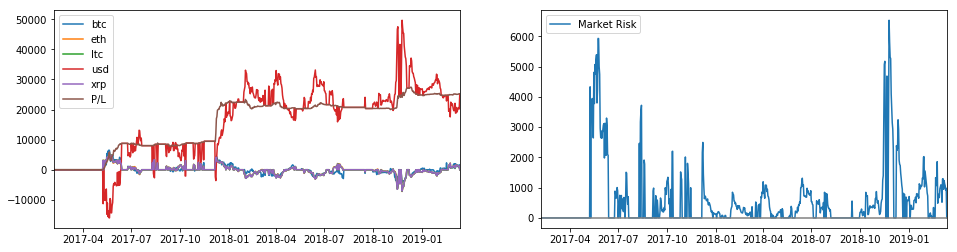

Return on market risk:        0.05753091399981272
Return on absolute positions: 0.01069341986560575
Final P/L:                    25225.33489890372
Maximum absolute drawdown:    3354.867674577865
Final balances:
usd    25225.334899
btc        0.000000
eth        0.000000
ltc        0.000000
xrp        0.000000
Name: 2019-03-14, dtype: float64


In [239]:
from strategy import MovingAverage
from numpy_ringbuffer import RingBuffer
from math import log1p, sqrt
from johansen.johansen import Johansen

def cointegrate(data):
    '''Returns eigenvectors for statistically-significant cointegration relations.
    TODO: return confidences, by using eigenvalues directly.'''
    eigenvectors, r = Johansen(data, model=2, significance_level=1).johansen()
    return np.array(eigenvectors)[r]

def plot_eigenvectors(evs):
    evs /= np.linalg.norm(evs, axis=1, keepdims=True)
    plot_matrix(pd.DataFrame(evs))

class Cointegrater(Strategy):
    def __init__(self, cointegration_window_size):
        '''edges are expressed in std deviations of the currency price
        size is $ per std dev. of edge'''
        self.cointegration_window = None
        self.cointegration_window_size = cointegration_window_size
        
    def step(self, prices, _volumes):
        if self.cointegration_window is None:
            self.cointegration_window = RingBuffer(self.cointegration_window_size, dtype=(np.float, len(prices.index)))
        
        self.cointegration_window.append(prices)
        
        if len(self.cointegration_window) < self.cointegration_window_size:
            return self.null_estimate(prices)
        
        df = pd.DataFrame(np.array(self.cointegration_window), columns = prices.index)
        
        relations = cointegrate(df)
        fairs = [] # 1 fair estimate per covariance relation
        for relation in relations:
            R = np.broadcast_to(relation, (prices.shape[0], prices.shape[0])).copy()
            R /= np.diag(R)[:None]
            np.fill_diagonal(R, 0)
            synth_cointegrations = pd.DataFrame(df.values.dot(R), columns = df.columns)
            fair_mean = prices + synth_cointegrations.iloc[-1] - synth_cointegrations.mean()
            fair_variance = synth_cointegrations.var()
            fairs.append(Gaussian(fair_mean, fair_variance))
        if len(fairs) > 0:
            return Gaussian.join(fairs)
        else:
            return self.null_estimate(prices)

plot_results(run(Cointegrater(cointegration_window_size = 64), tail_data(data, 1000)))

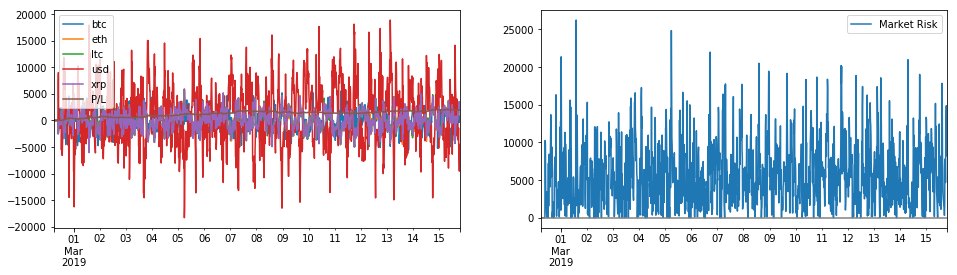

Return on market risk:        0.00023438776987120218
Return on absolute positions: 0.00024385192258306645
Final P/L:                    1963.7629271443407
Maximum absolute drawdown:    569.9606709535365
Final balances:
usd   -7161.387822
btc      -0.047551
eth      23.047198
ltc      51.009359
xrp    9843.220638
Name: 2019-03-15 19:00:00, dtype: float64


In [10]:
plot_results(run(Cointegrater(cointegration_window_size = 16), data_15min))

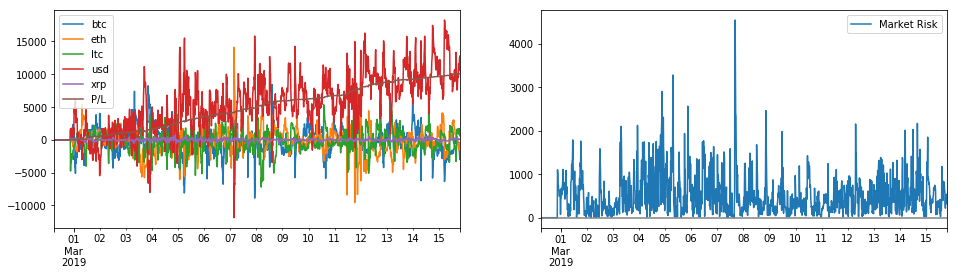

Return on market risk:        0.013256364765172033
Return on absolute positions: 0.00165261282100777
Final P/L:                    10072.004529960544
Maximum absolute drawdown:    373.6327170799359
Final balances:
usd    12749.255027
btc       -0.754805
eth       -2.898241
ltc       10.455755
xrp      247.134435
Name: 2019-03-15 19:00:00, dtype: float64


In [44]:
plot_results(run(KalmanFilter(correlation_window_size = 60, movement_half_life = 3), data_15min))

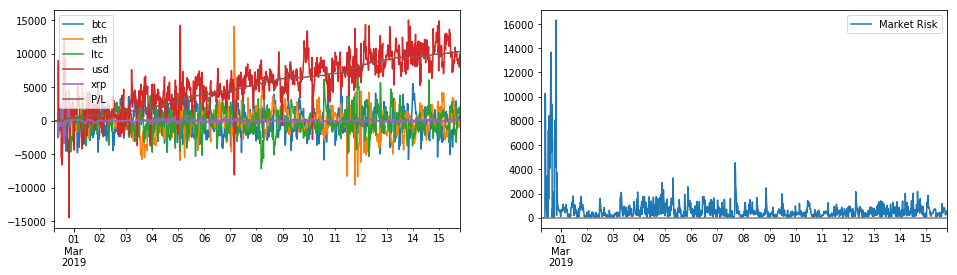

Return on market risk:        0.010690834312094279
Return on absolute positions: 0.0016420463888880132
Final P/L:                    10332.176123795964
Maximum absolute drawdown:    365.50208352390655
Final balances:
usd    9720.987123
btc      -0.096309
eth       0.718450
ltc      13.724038
xrp     249.272732
Name: 2019-03-15 19:00:00, dtype: float64


In [45]:
from strategy import CombinedStrategy

plot_results(run(CombinedStrategy([
    KalmanFilter(correlation_window_size = 60, movement_half_life = 3),
    Cointegrater(cointegration_window_size = 16)
]), data_15min))

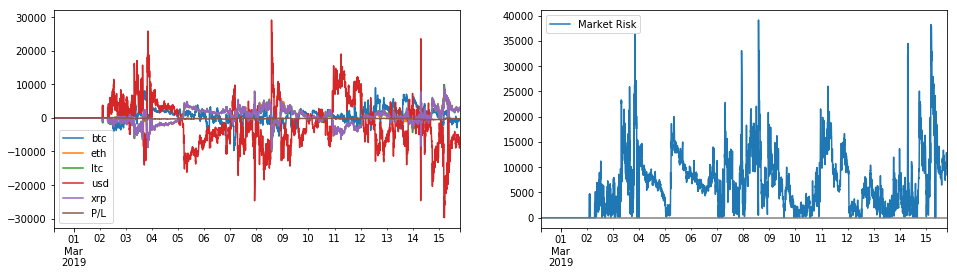

Return on market risk:        -7.428340110455235e-06
Return on absolute positions: -7.682477474984112e-06
Final P/L:                    -213.4662032657293
Maximum absolute drawdown:    844.1892504050857
Final balances:
usd   -7955.749066
btc      -0.205135
eth      20.260267
ltc      48.641316
xrp    8969.649387
Name: 2019-03-15 19:10:00, dtype: float64


In [39]:
plot_results(run(Cointegrater(cointegration_window_size = 512), data_5min))

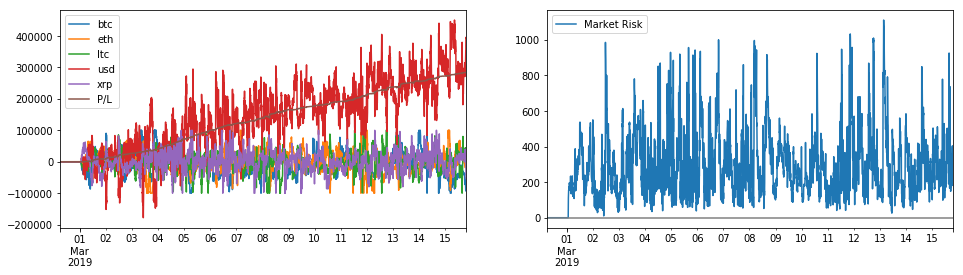

Return on market risk:        0.2219820853957714
Return on absolute positions: 0.0006671572225833165
Final P/L:                    283837.72659335774
Maximum absolute drawdown:    5662.290500859352
Final balances:
usd    395264.051264
btc       -21.207539
eth        16.787253
ltc       395.983669
xrp   -168949.532120
Name: 2019-03-15 19:10:00, dtype: float64


In [30]:
analyze(evaluate(KalmanFilter(correlation_window_size = 165, movement_half_life = 70), data_5min))

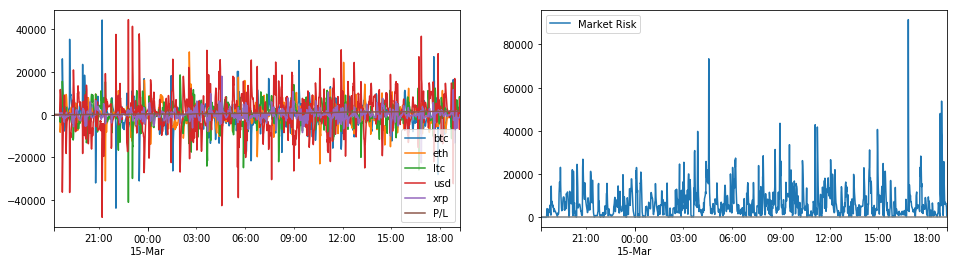

Return on market risk:        0.00016402489688799546
Return on absolute positions: 9.468930933405676e-05
Final P/L:                    1639.2274694422026
Maximum absolute drawdown:    222.99205408703665
Final balances:
usd    7340.844593
btc      -0.071257
eth     -11.338512
ltc     -63.354433
xrp    -277.029001
Name: 2019-03-15 19:13:00, dtype: float64


In [30]:
plot_results(run(CombinedStrategy([
    KalmanFilter(correlation_window_size = 16, movement_half_life = 8),
    Cointegrater(cointegration_window_size = 64)
]), tail_data(data_min, 1500)))

Trying window_size: 215 and half_life: 79.87936771139888
  RoR: 0.17311617585440975
Trying window_size: 121 and half_life: 6.212537462602108
  RoR: 0.1899185447538888
Trying window_size: 107 and half_life: 79.90842125720259
  RoR: 0.15132028825885938
Trying window_size: 165 and half_life: 70.94288261340017
  RoR: 0.2019962879665104
Trying window_size: 167 and half_life: 29.848107296600205
  RoR: 0.17758433879462587
Trying window_size: 60 and half_life: 1.7540906707347852
  RoR: 0.12032534753826656
Trying window_size: 124 and half_life: 13.892728662930411
  RoR: 0.16342175012599314
Trying window_size: 78 and half_life: 35.29888565964528
  RoR: 0.15080339333004827
Trying window_size: 92 and half_life: 10.979957444445429
  RoR: 0.16910642505888426
Trying window_size: 111 and half_life: 45.94492009720074
  RoR: 0.16851420367769174
Trying window_size: 130 and half_life: 16.969962146951808
  RoR: 0.16136107089585075
Trying window_size: 87 and half_life: 15.715187085517591
  RoR: 0.1624563865

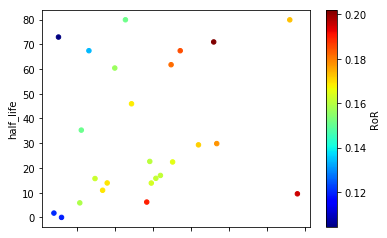

In [28]:
import random

def find_best_window_sizes(data, n):
    points = []
    best = None
    best_ror = 0
    for _ in range(n):
        movement_half_life = random.expovariate(1) * 30
#         window_ratio = random.uniform(1, 10)
#         window_size = max(3, int(movement_half_life * window_ratio))
#         movement_half_life = 2
        window_size = int(random.expovariate(1) * 60) + 60
#         window_size = int(random.expovariate(1) * 30) + 3
#         window_size = 4
#         window_size = 32
        print('Trying window_size: {0} and half_life: {1}'.format(window_size, movement_half_life))
        results = run(KalmanFilter(window_size, movement_half_life), data)
        ror = return_on_risk(results)
        print('  RoR: {0}'.format(ror))
        point = { 'window_size': window_size, 'half_life': movement_half_life, 'RoR': ror }
        points.append(point)
        if ror > best_ror:
            best = point
            best_ror = ror
    print('Best found:')
    print(best)
    pd.DataFrame(points).plot.scatter('window_size', 'half_life', c='RoR', colormap='jet')
    
find_best_window_sizes(tail_data(data_5min, 1000), 25)